In [277]:
import os
import datetime as dt
import mplfinance as mpf
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

In [278]:
# polars csv read
directory = "../../data/ES_CLEAN/"

all_years = []

for file in os.listdir(directory):
    df_temp = pl.scan_csv(directory + file)
    all_years.append(df_temp.collect())

df = pl.concat(all_years)
df.head()

Date,Time,Open,High,Low,Close,Volume
str,str,f64,f64,f64,f64,i64
"""1/5/2006""","""07:59:00""",1356.0,1356.0,1356.0,1356.0,8
"""1/5/2006""","""08:00:00""",1355.75,1356.0,1355.75,1356.0,51
"""1/5/2006""","""08:01:00""",1356.0,1356.0,1355.75,1355.75,31
"""1/5/2006""","""08:02:00""",1355.75,1355.75,1355.75,1355.75,44
"""1/5/2006""","""08:03:00""",1356.0,1356.0,1356.0,1356.0,6


In [287]:
# FUNCTIONS


def format_data(dataframe):
    dataframe = (
        dataframe.with_columns((pl.col("Date") + " " + pl.col("Time")).alias("New"))
        .drop("Date")
        .drop("Time")
        .select("New", "Open", "High", "Low", "Close", "Volume")
        .rename({"New": "Date"})
        .with_columns(pl.col("Date").str.to_datetime("%m/%d/%Y %H:%M:%S").alias("Date"))
    )
    return dataframe


def create_candlestick_chart(start, end, dataframe):
    dataframe = dataframe.filter(
        (pl.col("Date") >= start) & (pl.col("Date") <= end)
    ).to_pandas()
    dataframe.index = pd.DatetimeIndex(dataframe["Date"])

    # style
    colors = mpf.make_marketcolors(
        up="#b8bb26",
        down="#fb4934",
        wick="inherit",
        edge="i",
        volume="#fb4934",
    )
    mpf_style = mpf.make_mpf_style(
        base_mpf_style="binancedark", marketcolors=colors, gridcolor="#282828"
    )

    fig = mpf.plot(
        dataframe,
        type="candle",
        volume=True,
        style=mpf_style,
        scale_padding=0.1,
        figscale=1,
        figratio=(2, 1),
    )
    return fig


def create_time_range(year, month, day, hour):
    return (
        dt.datetime(year, month, day, hour=hour),
        dt.datetime(year, month, day, hour=hour + 2, minute=30),
    )

In [308]:
df_formatted = format_data(df)

df_formatted = df_formatted.with_columns((pl.col("Volume").shift(1)).alias("HVolume"))
df_formatted = df_formatted.with_columns(
    (pl.col("High").shift(-1)).alias("HighFirstCandle")
)
df_formatted = df_formatted.with_columns(
    (pl.col("Low").shift(-1)).alias("LowFirstCandle")
)
df_formatted = df_formatted.with_columns(
    (pl.col("Volume").shift(-1)).alias("VolumeFirstCandle")
)
df_formatted = df_formatted.with_columns(
    (pl.col("High").shift(-2)).alias("HighSecondCandle")
)
df_formatted = df_formatted.with_columns(
    (pl.col("Low").shift(-2)).alias("LowSecondCandle")
)
df_formatted = df_formatted.with_columns(
    (pl.col("Volume").shift(-2)).alias("VolumeSecondCandle")
)
df_formatted = df_formatted.with_columns((pl.col("Close").shift(6)).alias("Past"))

# current and past analysis
df_formatted = df_formatted.filter((pl.col("Volume") // 2) >= pl.col("HVolume"))
df_formatted = df_formatted.filter((pl.col("Past") < (pl.col("High") - 6)))
df_formatted = df_formatted.filter((pl.col("Close") > (pl.col("Open"))))

# next columns analysis
df_formatted = df_formatted.filter(pl.col("VolumeFirstCandle") < pl.col("Volume"))
df_formatted = df_formatted.filter(pl.col("HighFirstCandle") < (pl.col("High") + 1))
df_formatted = df_formatted.filter(pl.col("HighFirstCandle") > (pl.col("High") - 1))
df_formatted = df_formatted.filter(pl.col("LowFirstCandle") > (pl.col("Low")))
df_formatted = df_formatted.filter(pl.col("VolumeSecondCandle") < pl.col("Volume"))
df_formatted = df_formatted.filter(pl.col("HighSecondCandle") < (pl.col("High") + 1))
df_formatted = df_formatted.filter(pl.col("HighSecondCandle") > (pl.col("High") - 1))
df_formatted = df_formatted.filter(pl.col("LowSecondCandle") > (pl.col("Low")))

# df_formatted = df_formatted.with_columns()

# + shift == past; + shift == future
print(
    df_formatted.filter(pl.col("Date") > dt.datetime(2022, 2, 8, 10))
    .select("Date", "Volume", "Past")
    .head(10)
)

shape: (10, 3)
┌─────────────────────┬────────┬─────────┐
│ Date                ┆ Volume ┆ Past    │
│ ---                 ┆ ---    ┆ ---     │
│ datetime[μs]        ┆ i64    ┆ f64     │
╞═════════════════════╪════════╪═════════╡
│ 2022-02-08 10:32:00 ┆ 7994   ┆ 4718.5  │
│ 2022-02-13 17:46:00 ┆ 1270   ┆ 4633.75 │
│ 2022-02-14 04:39:00 ┆ 691    ┆ 4595.25 │
│ 2022-02-15 12:22:00 ┆ 4904   ┆ 4673.5  │
│ 2022-02-16 02:16:00 ┆ 3862   ┆ 4680.25 │
│ 2022-02-16 10:08:00 ┆ 4988   ┆ 4659.25 │
│ 2022-02-17 06:02:00 ┆ 1318   ┆ 4669.5  │
│ 2022-02-17 18:57:00 ┆ 331    ┆ 4594.5  │
│ 2022-02-18 08:31:00 ┆ 13753  ┆ 4595.5  │
│ 2022-02-18 10:21:00 ┆ 4583   ┆ 4572.5  │
└─────────────────────┴────────┴─────────┘


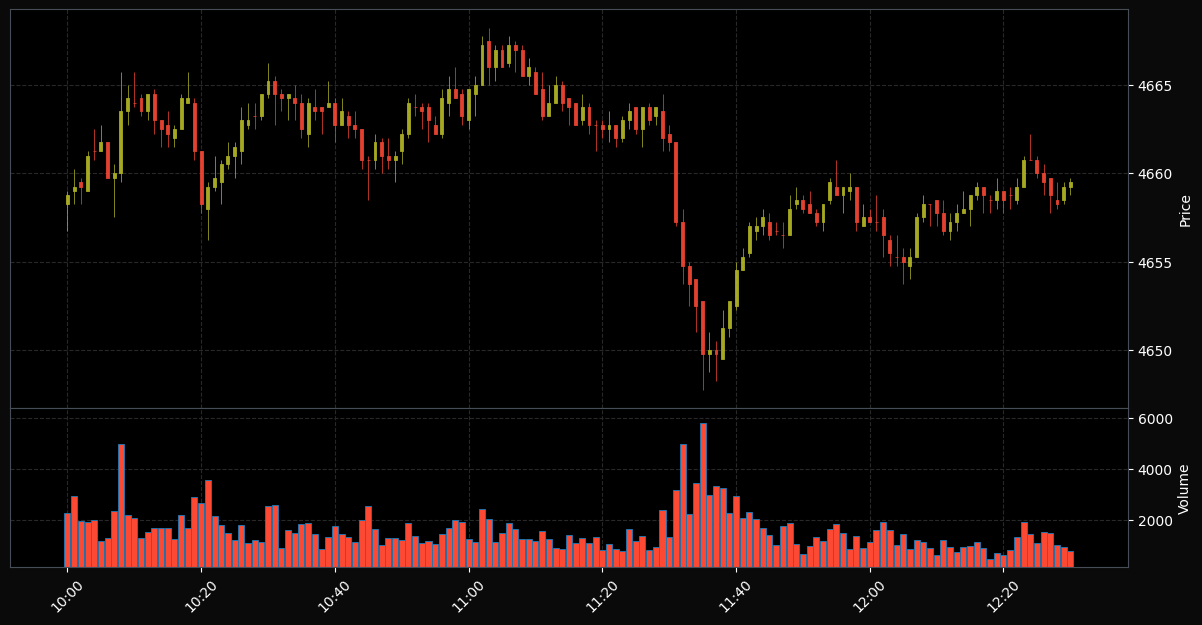

In [310]:
time = create_time_range(year=2022, month=2, day=16, hour=10)
create_candlestick_chart(*time, format_data(df))